In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import tensor
import numpy as np
import torchvision
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam, lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil
import glob
import torchmetrics
import pathlib
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
from sklearn.model_selection import StratifiedKFold
import subprocess
import h5py

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def train_model(model, criterion, optimizer, scheduler,  dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()
    torch.cuda.reset_peak_memory_stats(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # create a list to store the training and validation accuracy values
    train_acc_list = []
    val_acc_list = []

    # create a list to store the training and validation loss values
    train_loss_list = []
    val_loss_list = []

    # initialize metric
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=3)
    predicted_labels = []
    ground_truth_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        #Training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #_,preds = torch.max(outputs,1)
                    #loss = criterion(outputs,labels)
                    #googlenetcprfix
                    if str(type(outputs)) == "<class 'torch.Tensor'>":
                        _,preds = torch.max(outputs,1)
                        loss = criterion(outputs,labels)
                    else :
                        _,preds = torch.max(outputs.logits,1)
                        loss = criterion(outputs.logits,labels)

                    #backward + optimize only in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            elif phase == 'val':
                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

            predicted_labels.append(preds.cpu())
            ground_truth_labels.append(labels.cpu())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #calculate accuracy
    predicted_labels = torch.cat(predicted_labels)
    ground_truth_labels = torch.cat(ground_truth_labels)
    accuracy = Accuracy(task="multiclass", num_classes=3)
    accuracy(predicted_labels, ground_truth_labels)
    print(f'Accuracy: {accuracy.compute():.4f}')

    #calculate precision
    precision = Precision(task="multiclass", average='macro', num_classes=3)
    precision(predicted_labels, ground_truth_labels)
    print(f'Precision: {precision.compute():.4f}')

    #calculate recall
    recall = Recall(task="multiclass", average='macro', num_classes=3)
    recall(predicted_labels, ground_truth_labels)
    print(f'Recall: {recall.compute():.4f}')

    #calculate f1 score
    f1 = F1Score(task="multiclass", average='macro', num_classes=3)
    f1(predicted_labels, ground_truth_labels)
    print(f'F1: {f1.compute():.4f}')

    #calculate confusion matrix
    cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=3, task="multiclass")
    print(f'Confusion Matrix: \n{cm}')

    #plot the training and validation accuracy
    plt.figure(figsize=(10, 6))

    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    #plot the training and validation loss

    plt.figure(figsize=(10, 6))

    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

    metrics = {}
    metrics['accuracy'] = accuracy.compute()
    metrics['precision'] = precision.compute()
    metrics['recall'] = recall.compute()
    metrics['f1'] = f1.compute()
    metrics['time'] = time_elapsed
    metrics['memory'] = torch.cuda.max_memory_allocated()/(1024*1024)


    #load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics


In [4]:
def print_metrics(metrics):
  #total_time = metrics["time"]*5
  print(f'Average accuracy: {metrics["accuracy"]:.4f}')
  print(f'Average precision: {metrics["precision"]:.4f}')
  print(f'Average recall: {metrics["recall"]:.4f}')
  print(f'Average F1 score: {metrics["f1"]:.4f}')
  print(f'Average Time elapsed: {metrics["time"]:.4f} seconds')
  print(f'Memory Usage: {metrics["memory"]:.4f} MiB')

In [5]:
def get_transforms():
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    data_transforms = {
          'train':transforms.Compose([
              transforms.RandomResizedCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'val':transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
    return data_transforms

In [6]:
with h5py.File(os.path.join('../../datasets', 'ecg_data', 'train_ecg.hdf5'), 'r') as hdf:
    x = hdf['x_train'][:2]
    y = hdf['y_train'][:2]
    print(f'x: {x}\n y: {y}')

x: [[[0.47621218 0.50096342 0.50294299 0.46303273 0.42054075 0.41794807
   0.4286182  0.4462329  0.46512831 0.47410243 0.47995983 0.4869455
   0.48992241 0.48249982 0.47189347 0.45860304 0.45215176 0.47244653
   0.49538254 0.49949936 0.49843796 0.49746782 0.49496506 0.49164869
   0.48723655 0.47869662 0.47326381 0.48292294 0.49338693 0.49148231
   0.48655512 0.48339012 0.47962191 0.47454021 0.46900796 0.46349089
   0.45822001 0.4537282  0.44976588 0.4461381  0.44324834 0.44168869
   0.44081725 0.44166378 0.44085934 0.43157546 0.42303933 0.42270658
   0.42794644 0.4434478  0.45932207 0.46661455 0.46780117 0.4576057
   0.44544252 0.44163622 0.43875378 0.42123444 0.41866177 0.47364785
   0.53976035 0.58573583 0.61824316 0.61711256 0.6146758  0.6628272
   0.69504284 0.65627981 0.57122772 0.41926656 0.27023215 0.20549378
   0.17710238 0.17789824 0.1925988  0.2052016  0.21025276 0.17646282
   0.1490476  0.1799834  0.22196145 0.24002636 0.25688267 0.28234373
   0.3120003  0.34833855 0.3848328

In [7]:
def preTrainImageNet(model_name, classes):
  data_transforms = get_transforms()
  # Get a list of all image filenames and corresponding labels
  all_filenames = []
  all_labels = []
  # Iterate through each class folder and associate each image with corresponding lable
  for class_name in classes:
      folder_path = './THB_dataset'
      class_folder = os.path.join(folder_path, class_name)
      class_filenames = [os.path.join(class_folder, filename) for filename in os.listdir(class_folder)]

      # Extend the list of all_filenames and all_labels
      all_filenames.extend(class_filenames)
      all_labels.extend([class_name] * len(class_filenames))

  # Use StratifiedKFold for creating folds
  num_folds = 5
  stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

  all_metrics = []

  # Perform stratified k-fold cross-validation
  for i, (train_idx, test_idx) in enumerate(stratified_kfold.split(all_filenames, all_labels)):
    train_FileNames = [all_filenames[idx] for idx in train_idx]
    val_FileNames = [all_filenames[idx] for idx in test_idx]
    print('Fold: ',i)
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    fold_dir = f'./splitted_dataset/fold{i}'
    if not os.path.exists(fold_dir):
        os.makedirs(fold_dir+'/train')
        os.makedirs(fold_dir+'/val')

        # Creating the class folders in train and validation folders
        for class_name in classes:
            os.makedirs(fold_dir+'/train/' + class_name)
            os.makedirs(fold_dir+'/val/' + class_name)
    
        for name in train_FileNames:
            name_split = name.split('\\')
            class_name = name_split[1] + '/' + name_split[2]
            shutil.copy(name, fold_dir+'/train/' + class_name)
        for name in val_FileNames:
            name_split = name.split('\\')
            class_name = name_split[1] + '/' + name_split[2]
            shutil.copy(name, fold_dir+'/val/' + class_name)


    sets = ['train','val']
    image_datasets = {x:datasets.ImageFolder(os.path.join(fold_dir,x),
                                            data_transforms[x])
                    for x in ['train','val']}
    dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                                shuffle=True,num_workers=0)
                    for x in ['train','val']}

    dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}


    pretrained_model_ImageNet = models.squeezenet1_1(pretrained=True)

    #freezing previous layers
    for param in pretrained_model_ImageNet.features.parameters():
        param.requires_grad = False

    #exchange the last layer
    num_classes = 3

    if model_name in ['googlenet', 'resnet18']:
        pretrained_model_ImageNet.fc = nn.Linear(in_features=pretrained_model_ImageNet.fc.in_features, out_features=num_classes, device=device)
    elif model_name in ['alexnet', 'vgg16']:
        num_ftrs = pretrained_model_ImageNet.classifier[6].in_features
        pretrained_model_ImageNet.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'squeezenet':
        # Newly created modules have require_grad=True by default
        num_features = pretrained_model_ImageNet.classifier[1].in_channels
        features = list(pretrained_model_ImageNet.classifier.children())[:-3] # Remove last 3 layers
        features.extend([nn.Conv2d(num_features, num_classes, kernel_size=1)]) # Add
        features.extend([nn.ReLU(inplace=True)]) # Add
        features.extend([nn.AdaptiveAvgPool2d(output_size=(1,1))]) # Add
        pretrained_model_ImageNet.classifier = nn.Sequential(*features)

    elif model_name == 'inceptionv3':
        num_ftrs = pretrained_model_ImageNet.fc.in_features
        pretrained_model_ImageNet.fc = nn.Linear(num_ftrs, 3)
    else:
        #use voltavision here.
        raise ValueError(f"Invalid model_name: {model_name}")

    pretrained_model_ImageNet.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(pretrained_model_ImageNet.parameters(),lr=0.001)

    #scheduler
    step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

    model_ft, metrics = train_model(pretrained_model_ImageNet, criterion, optimizer, step_lr_scheduler, dataloaders, dataset_sizes, num_epochs=25)

    all_metrics.append(metrics)

  avg_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
  print_metrics(avg_metrics)
  # print_performance()

In [8]:
folder_path = 'THB_dataset'
classes = os.listdir(folder_path)
print(classes)

['Bluetooth', 'Humidity', 'Transistor']


Fold:  0
Training:  262
Validation:  66


C:\Users\ishmu\anaconda3\envs\pyenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ishmu\anaconda3\envs\pyenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.7677 Acc: 0.6527
val Loss: 0.3215 Acc: 0.9242

Epoch 1/24
----------
train Loss: 0.3761 Acc: 0.8664
val Loss: 0.1988 Acc: 0.9697

Epoch 2/24
----------
train Loss: 0.3073 Acc: 0.9122
val Loss: 0.1243 Acc: 0.9545

Epoch 3/24
----------
train Loss: 0.2266 Acc: 0.9198
val Loss: 0.0953 Acc: 0.9848

Epoch 4/24
----------
train Loss: 0.1664 Acc: 0.9656
val Loss: 0.0842 Acc: 0.9848

Epoch 5/24
----------
train Loss: 0.1649 Acc: 0.9427
val Loss: 0.0648 Acc: 0.9848

Epoch 6/24
----------
train Loss: 0.1486 Acc: 0.9656
val Loss: 0.0578 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1270 Acc: 0.9580
val Loss: 0.0577 Acc: 0.9848

Epoch 8/24
----------
train Loss: 0.1308 Acc: 0.9656
val Loss: 0.0592 Acc: 0.9848

Epoch 9/24
----------
train Loss: 0.0973 Acc: 0.9809
val Loss: 0.0572 Acc: 0.9848

Epoch 10/24
----------
train Loss: 0.1140 Acc: 0.9695
val Loss: 0.0581 Acc: 0.9848

Epoch 11/24
----------
train Loss: 0.1409 Acc: 0.9542
val Loss: 0.0568 Acc: 0.9848

Ep

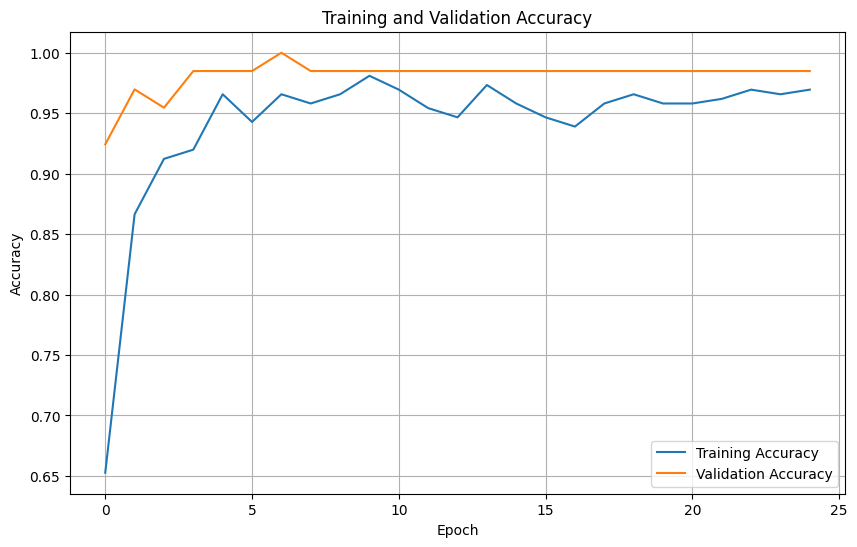

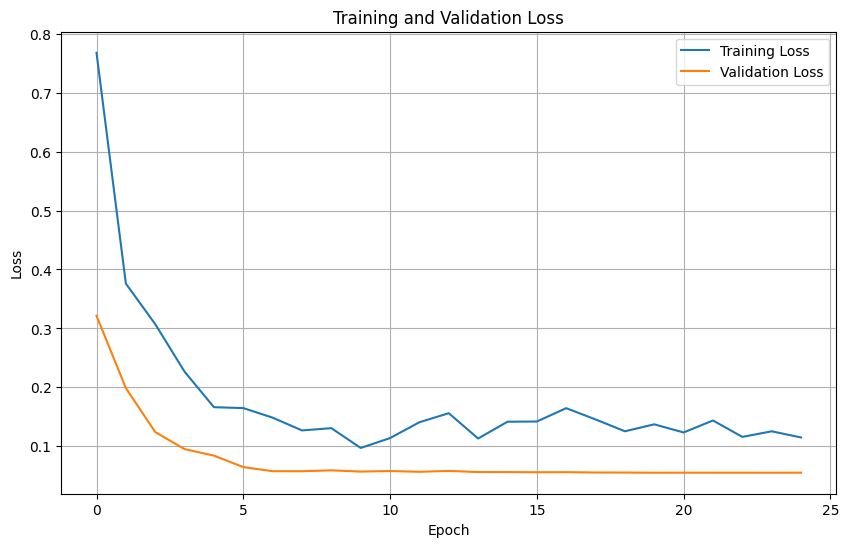

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.7355 Acc: 0.6679
val Loss: 0.3938 Acc: 0.8636

Epoch 1/24
----------
train Loss: 0.3792 Acc: 0.8702
val Loss: 0.2077 Acc: 0.9394

Epoch 2/24
----------
train Loss: 0.2504 Acc: 0.9160
val Loss: 0.1724 Acc: 0.9545

Epoch 3/24
----------
train Loss: 0.2107 Acc: 0.9313
val Loss: 0.1166 Acc: 0.9697

Epoch 4/24
----------
train Loss: 0.1980 Acc: 0.9313
val Loss: 0.1262 Acc: 0.9545

Epoch 5/24
----------
train Loss: 0.1588 Acc: 0.9466
val Loss: 0.0985 Acc: 0.9545

Epoch 6/24
----------
train Loss: 0.1363 Acc: 0.9618
val Loss: 0.0978 Acc: 0.9697

Epoch 7/24
----------
train Loss: 0.1328 Acc: 0.9656
val Loss: 0.1011 Acc: 0.9545

Epoch 8/24
----------
train Loss: 0.1523 Acc: 0.9389
val Loss: 0.0987 Acc: 0.9545

Epoch 9/24
----------
train Loss: 0.1473 Acc: 0.9542
val Loss: 0.0961 Acc: 0.9697

Epoch 10/24
----------
train Loss: 0.1776 Acc: 0.9466
val Loss: 0.0971 Acc: 0.9545

Epoch 11/24
----------
train Loss: 0.1039 Acc:

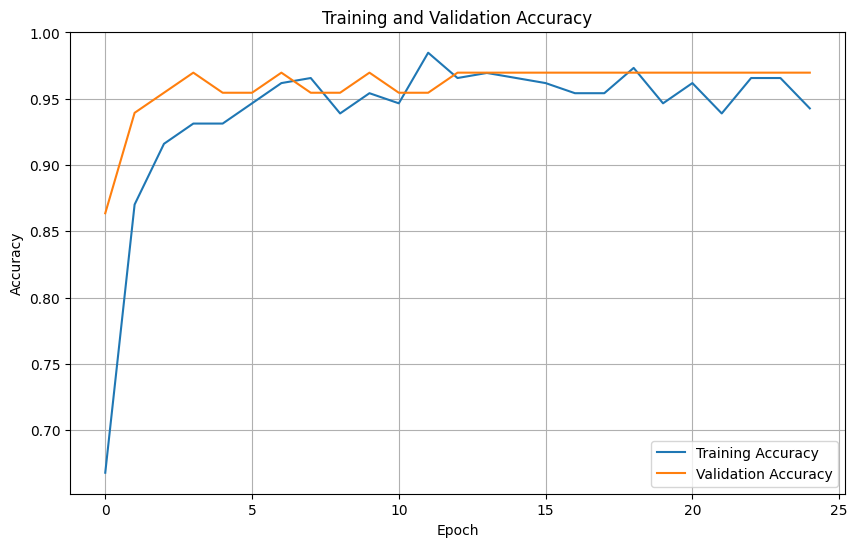

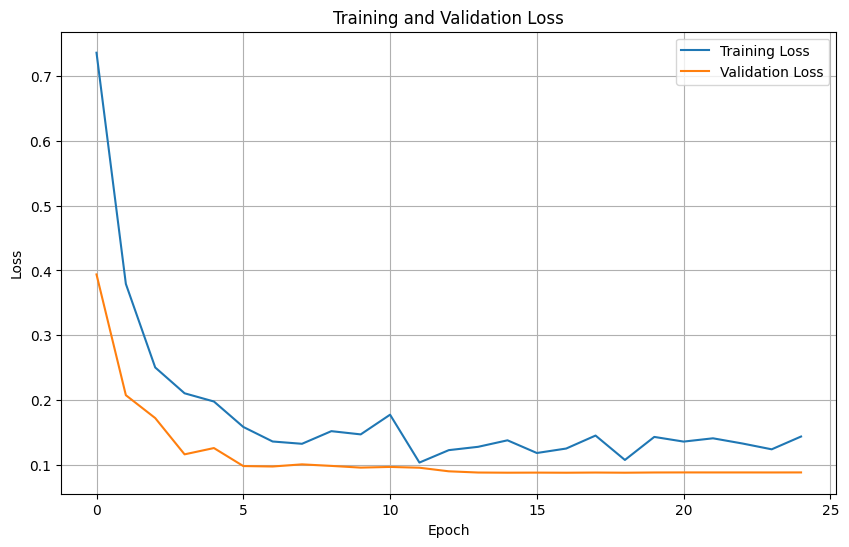

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.8392 Acc: 0.6450
val Loss: 0.4601 Acc: 0.8636

Epoch 1/24
----------
train Loss: 0.4223 Acc: 0.8435
val Loss: 0.3005 Acc: 0.8485

Epoch 2/24
----------
train Loss: 0.3108 Acc: 0.8779
val Loss: 0.1821 Acc: 0.9242

Epoch 3/24
----------
train Loss: 0.2565 Acc: 0.9160
val Loss: 0.2345 Acc: 0.8788

Epoch 4/24
----------
train Loss: 0.1966 Acc: 0.9389
val Loss: 0.1509 Acc: 0.9242

Epoch 5/24
----------
train Loss: 0.1892 Acc: 0.9427
val Loss: 0.1004 Acc: 0.9697

Epoch 6/24
----------
train Loss: 0.1971 Acc: 0.9313
val Loss: 0.0921 Acc: 0.9545

Epoch 7/24
----------
train Loss: 0.1349 Acc: 0.9771
val Loss: 0.0877 Acc: 0.9545

Epoch 8/24
----------
train Loss: 0.1313 Acc: 0.9656
val Loss: 0.0834 Acc: 0.9697

Epoch 9/24
----------
train Loss: 0.1296 Acc: 0.9656
val Loss: 0.0815 Acc: 0.9697

Epoch 10/24
----------
train Loss: 0.1016 Acc: 0.9733
val Loss: 0.0818 Acc: 0.9697

Epoch 11/24
----------
train Loss: 0.1235 Acc:

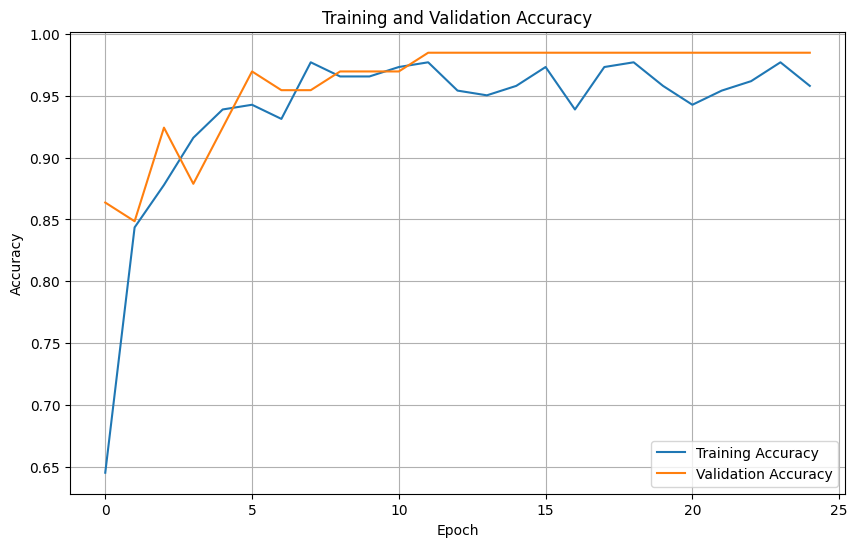

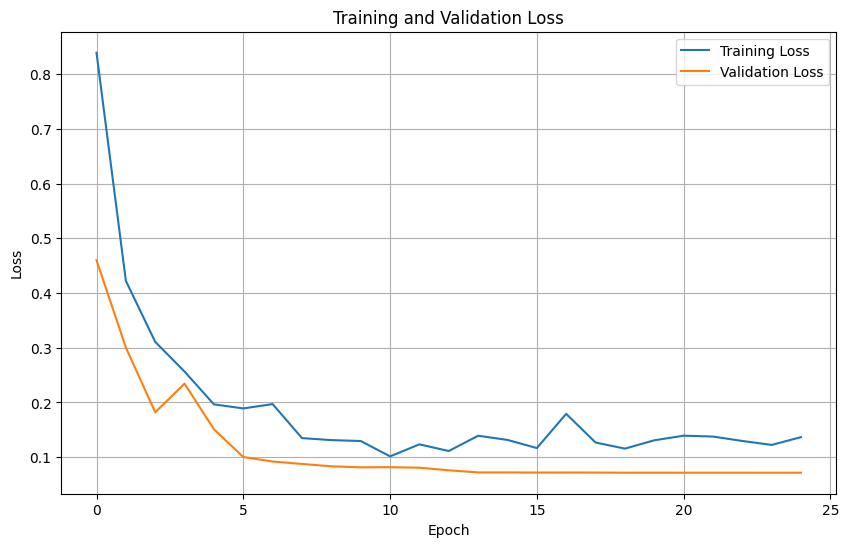

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.7005 Acc: 0.7186
val Loss: 0.4793 Acc: 0.8154

Epoch 1/24
----------
train Loss: 0.4014 Acc: 0.8593
val Loss: 0.3336 Acc: 0.9231

Epoch 2/24
----------
train Loss: 0.2599 Acc: 0.9392
val Loss: 0.2194 Acc: 0.9231

Epoch 3/24
----------
train Loss: 0.2358 Acc: 0.9202
val Loss: 0.1740 Acc: 0.9231

Epoch 4/24
----------
train Loss: 0.1833 Acc: 0.9544
val Loss: 0.1669 Acc: 0.9231

Epoch 5/24
----------
train Loss: 0.1835 Acc: 0.9354
val Loss: 0.1759 Acc: 0.9385

Epoch 6/24
----------
train Loss: 0.1226 Acc: 0.9658
val Loss: 0.1110 Acc: 0.9538

Epoch 7/24
----------
train Loss: 0.1426 Acc: 0.9544
val Loss: 0.1285 Acc: 0.9538

Epoch 8/24
----------
train Loss: 0.1228 Acc: 0.9696
val Loss: 0.1282 Acc: 0.9538

Epoch 9/24
----------
train Loss: 0.1861 Acc: 0.9506
val Loss: 0.1381 Acc: 0.9538

Epoch 10/24
----------
train Loss: 0.1144 Acc: 0.9658
val Loss: 0.1385 Acc: 0.9538

Epoch 11/24
----------
train Loss: 0.1287 Acc:

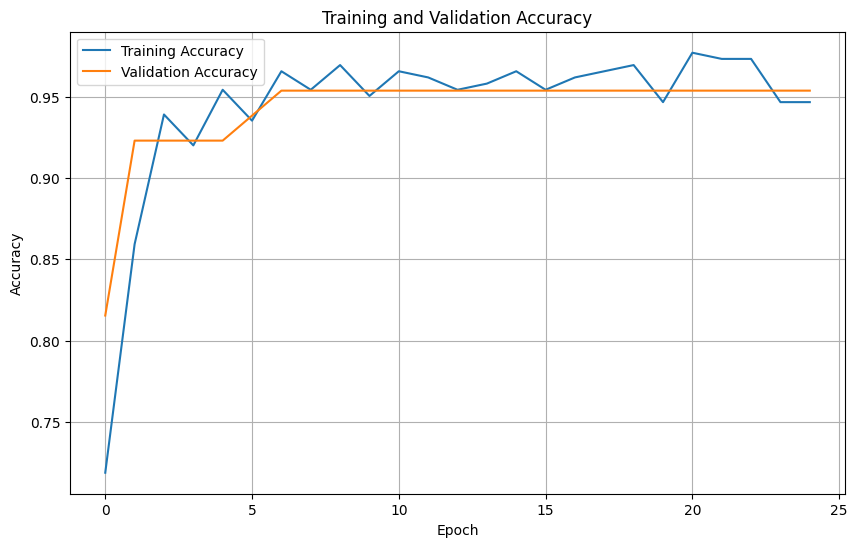

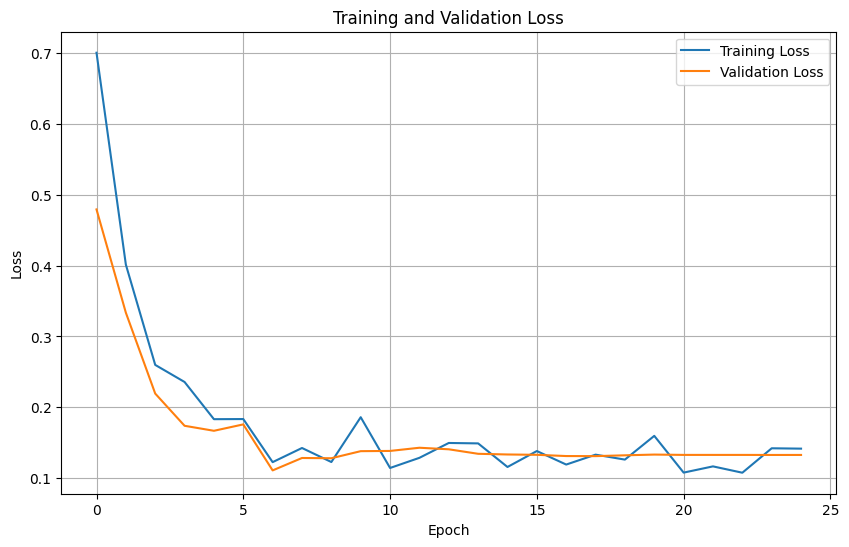

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.7587 Acc: 0.6616
val Loss: 0.3303 Acc: 0.9385

Epoch 1/24
----------
train Loss: 0.3743 Acc: 0.8821
val Loss: 0.1665 Acc: 0.9538

Epoch 2/24
----------
train Loss: 0.3498 Acc: 0.9049
val Loss: 0.0880 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.2365 Acc: 0.9202
val Loss: 0.0607 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.1836 Acc: 0.9506
val Loss: 0.0476 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1842 Acc: 0.9544
val Loss: 0.0580 Acc: 0.9846

Epoch 6/24
----------
train Loss: 0.1814 Acc: 0.9430
val Loss: 0.0340 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1614 Acc: 0.9392
val Loss: 0.0346 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1484 Acc: 0.9430
val Loss: 0.0333 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1817 Acc: 0.9316
val Loss: 0.0346 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1183 Acc: 0.9468
val Loss: 0.0323 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1090 Acc:

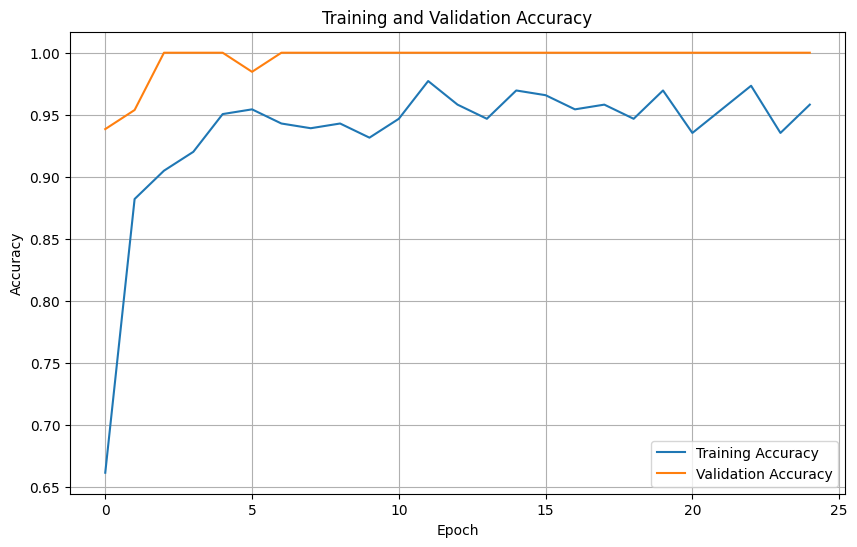

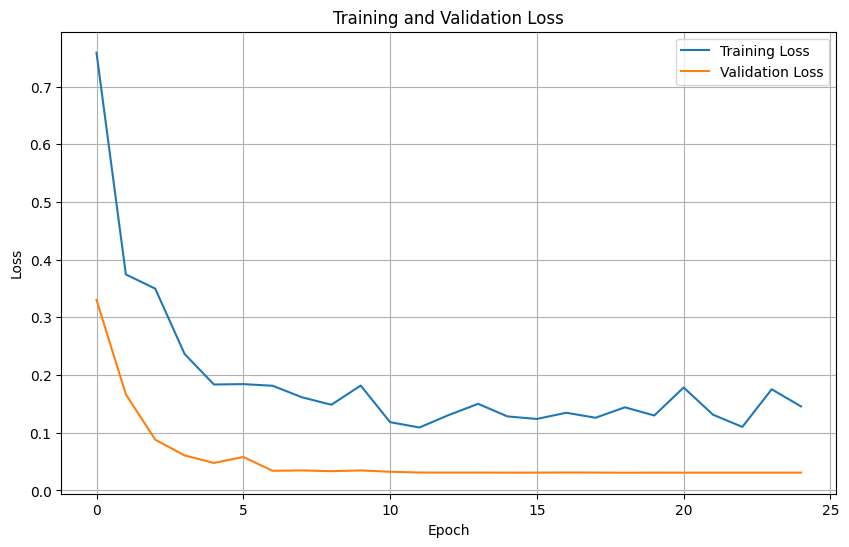

Average accuracy: 0.9600
Average precision: 0.9622
Average recall: 0.9601
Average F1 score: 0.9600
Average Time elapsed: 92.0397 seconds
Memory Usage: 144.9242 MiB


In [9]:
preTrainImageNet("squeezenet",classes)